### Project Ideas

#### Using data from the National Oceanic and Atomospheric Administration (NOAA)
- Climate at a glance gives times series data for different parameters (avg/min/max temp, precipitation, palmer indices, cooling and heating days)
- Can average over different time scales
- Good visualizations are readily accessible
- Rankings data available
- Data comes from the nClimDiv Dataset
- JSON files are readily available

### Purpose of This Notebook

This notebook will be used to do some preliminary exploratory data analysis on the average temperature data for the contiguous United States starting from the year 1940. We basically just want to practice getting the publicly available data from NOAA (this data does not require an API) and visualize it. Basic visualizations will reveal the yearly seasonality. We'll also do some decomposition to get the trends for each state. Finally, we'll use the Dickey-Fuller test to check the stationarity of the temperature data for each state.

### Things To Do:

- Verify state codes
- Find a way to represent each state time series neatly in a single DataFrame
- Get data for the other indicators in the climate at a glance section
- Introduce functionality to save data into CSVs so that it doesn't need to be requested again later

In [2]:
import pandas as pd
import pandas.tseries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json
import statsmodels.api as sm

%matplotlib inline

### Getting Data for Each Metric

The data for this project has been collected and stored as csvs using the code in 'data_fetching.ipynb.' 
Here we will just be reading it in as dataframes and storing each dataframe as an entry in a dictionary

In [3]:
metrics = ['tavg', 'tmax', 'tmin', 'pcp', 'cdd', 'hdd', 'pdsi', 'phdi', 'pmdi']
all_dfs = {metric: pd.read_csv(f'cag_csvs/{metric}.csv', 
                               index_col='Date', 
                               parse_dates=['Date'])
           for metric in metrics}

### Visualizations
Let's take a look at some of the temperature data

C:\Users\ducha\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1801: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


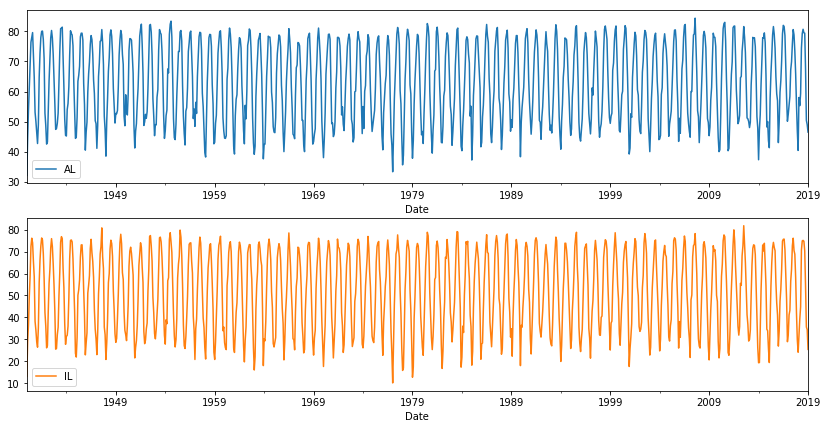

In [10]:
avg_t_df = all_dfs['tavg']

fig, ax = plt.subplots(figsize=(14,7))
avg_t_df.plot(y=['AL', 'IL'], ax=ax, subplots=True);

There is an obvious yearly seasonality here. Let's try decomposing so that we can confirm this and hopefully see the trend.

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

<Figure size 432x288 with 0 Axes>

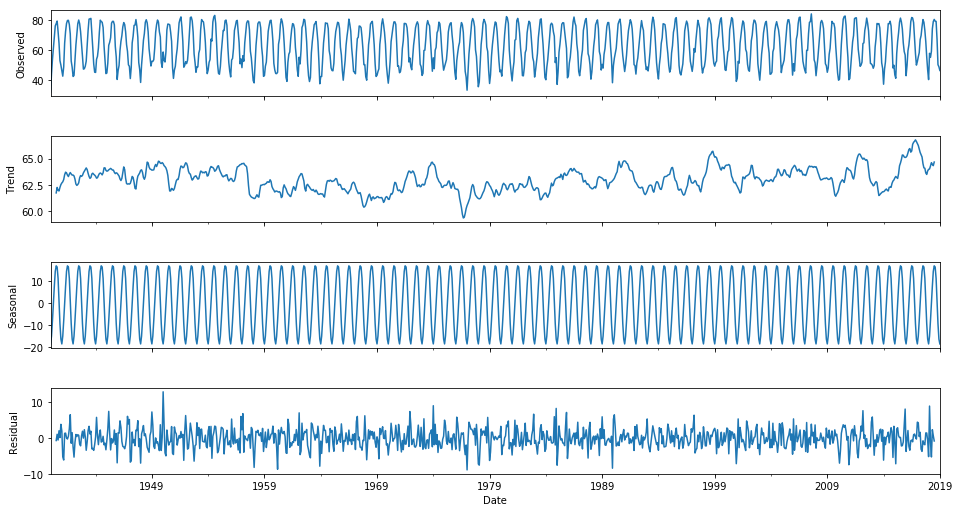

In [20]:
decomposition = seasonal_decompose(avg_t_df['AL'], freq=12)
fig = plt.figure()
fig = decomposition.plot();
fig.set_size_inches(15,8)

### Checking Stationarity

Now that we have a good idea about what the temperature data looks like, we'll check for stationarity

In [22]:
from statsmodels.tsa.stattools import adfuller

In [31]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

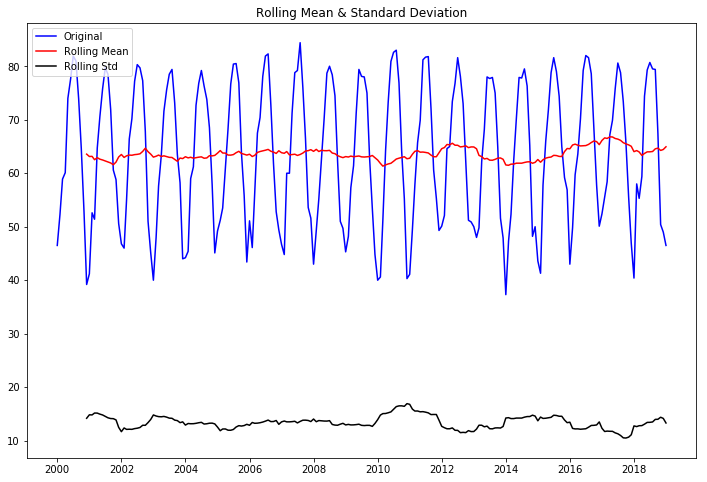

Results of Dickey-Fuller Test:
Test Statistic                  -2.870025
p-value                          0.048946
#Lags Used                      11.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


In [60]:
test_stationarity(avg_t_df['AL']['2000':])

Years 1940-2019 don't show any trend really. For our model, we want to make sure that there is a noticeable trend in order to capture the increase in temperature. When doing a Dickey-Fuller test on data from 2000 onwards, the p-value approaches 0.05 for average temperature data from Alabama. So, as a first step we'll run Dickey-Fuller tests on all of the average temperature data from 2000 onwards.

In [92]:
def calc_d_fuller(df, start_year):
    """
    Runs a Dickey-Fuller test for all state time series within a given dataframe.
    Returns a DataFrame with the Results of the Dickey-Fuller test for each state time 
    series. 
    """
    test_stats, p_vals, n_lags = {}, {}, {}
    
    for state in df.columns:
        results = adfuller(df[state][start_year:], autolag='AIC')
        test_stats[state] = results[0]
        p_vals[state] = results[1]
        n_lags[state] = results[2]
        
    results_df = pd.DataFrame([test_stats, p_vals, n_lags],
                              index=['test_stat', 'p_value', 'n_lags'])
    
    return results_df.T
        

In [93]:
dfuller_avg_t_df = calc_d_fuller(avg_t_df, '2000')
sum(dfuller_avg_t_df['p_value'] >= 0.05)

17

In [95]:
dfuller_avg_t_df[duller_avg_t_df.p_value < 0.05]

,test_stat,p_value,n_lags
AL,-2.870025,0.048946,11.0
CO,-2.979735,0.036831,11.0
CT,-3.739511,0.003591,15.0
DE,-3.139731,0.023749,11.0
GA,-2.924781,0.042541,11.0
IN,-2.865942,0.049454,11.0
KY,-2.978509,0.036951,11.0
MA,-3.237261,0.017927,10.0
MD,-3.088163,0.027442,11.0
ME,-3.995871,0.001432,15.0


With months starting in the year 2000, 17 of our 48 timeseries appear to not be stationary. This seems like a good enough year to start for with predictions in order to catch the trend.

In [96]:
dfuller_avg_t_df = calc_d_fuller(avg_t_df.diff().dropna(), '2000')
sum(dfuller_avg_t_df['p_value'] >= 0.05)

0

After we difference to first order, all of the series end up being stationary

### Finding the Optimal Parameters

Now that we've checked stationarity, we can move on to finding the optimal parameters for our SARIMA models. 

In [103]:
avg_t_df_2000 = avg_t_df['2000':]
avg_t_df_2000_diff = avg_t_df_2000.diff().dropna()

In [102]:
plt.close('all')

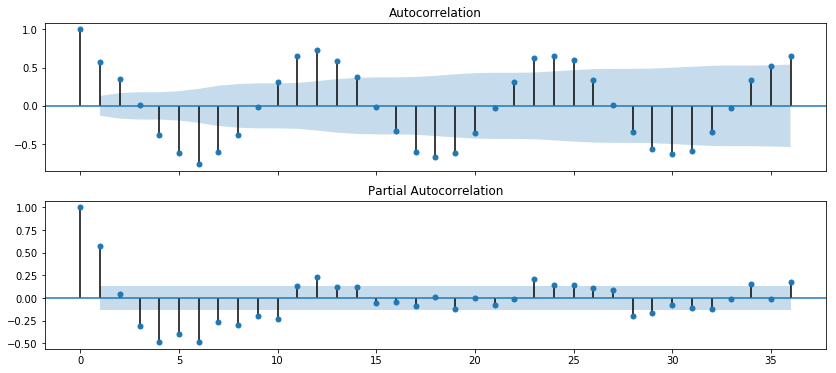

In [135]:
AL_avg_temp = all_dfs['tavg']['AL']
fig, (axs1, axs2) = plt.subplots(2,1, figsize=(14,6), sharex=True)
sm.graphics.tsa.plot_acf(avg_t_df_2000_diff['IL'], lags=36, ax=axs1);
sm.graphics.tsa.plot_pacf(avg_t_df_2000_diff['IL'], lags=36, ax=axs2);

In [139]:
model = SARIMAX(avg_t_df_2000['IL'], order=(0,0,1), 
                seasonal_order=(1,1,1,12))
results = model.fit()
results.summary()

C:\Users\ducha\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                 IL   No. Observations:                  229
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -615.868
Date:                            Mon, 06 Jan 2020   AIC                           1239.736
Time:                                    18:47:42   BIC                           1253.255
Sample:                                01-01-2000   HQIC                          1245.197
                                     - 01-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2009      0.058      3.485      0.000       0.088       0.314
ar.S.L12       0.0391      0.071      0.550      0.582      -0.100       0.178
ma.S.L12      -0.9964      1.586     -0.628      0.530      -4.105       2.112
sigma2        14.6193     22.664      0.645      0.519     -29.801      59.040
===================================================================================
Ljung-Box (Q):                       74.47   Jarque-Bera (JB):                 6.17
Prob(Q):                              0.00   Prob(JB):                         0.05
Heteroskedasticity (H):               1.34   Skew:                             0.25
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

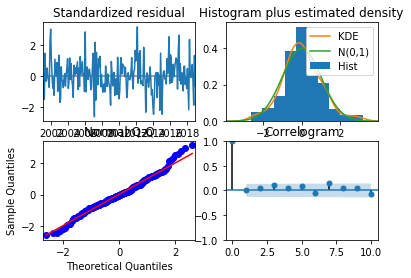

In [141]:
results.plot_diagnostics();

In [129]:
start = round(len(avg_t_df_2000['IL'])*0.8)
end = len(avg_t_df_2000_diff['IL'])

(730120.0, 737425.0)

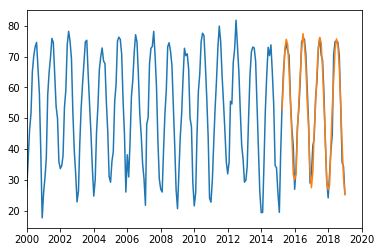

In [130]:
IL_forecast = results.predict(start=start, end=end)
plt.plot(avg_t_df_2000['IL'])
plt.plot(IL_forecast)
plt.xlim('2000', '2020')